# GAMMA Challenge Subtask 2 - Marco

<font color=red>Attention before running:    
You must comfirm those code according to your requirements:  
1. fh, fw = 1024, 1024 （in class FundusDataset)</font> <font color=red>  
2. if avg_ED <= 0.035 and avg_ED <= best_ED: （the saving conditions in train())</font> <font color=red>  
3. alpha</font>  




In [ ]:
!unzip -o /home/aistudio/data/data100624/GAMMA_training_data.zip  -d /home/aistudio/

In [ ]:
!mv -u best_model_0.0289 trained_models

In [ ]:
### remove the extraneous files in the data folder
!rm */.DS_Store
!rm */*/.DS_Store
!rm */*/*/.DS_Store

In [1]:
### import the necessary packages

import sys 
sys.path.append('/home/aistudio/external-libraries')
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances 
import matplotlib.pylab as plt

import paddle
import paddle.nn as nn
from paddle.vision.models import resnet50, resnet101, resnet152
from paddle.io import Dataset
import transforms as trans 
import functional as F
import logging 
from datetime import datetime


### **Config**

In [2]:
### set the parameters in your framework

path = 'training_data/multi-modality_images'  # the path to the training data
image_idxs = os.listdir(path)
file_list = [image_idxs[i] for i in range(len(image_idxs))] 
# print(file_list) 
images_file=[]         # the list of fundus images' path
for i in range(len(image_idxs)):
    real_index = file_list[i]
    fundus_img_path = os.path.join(path, real_index, real_index + '.jpg')
    images_file.append(fundus_img_path)
images_file.sort()
# print(images_file)
# images_file = path + 'fundus_image/'
# gt_file = path + 'Fovea_Location_train.xlsx'
gt_file = 'training_data/fovea_localization_training_GT.xlsx'

image_size = 512 # the image size to the network (image_size, image_size, 3)
val_ratio = 0.1 # the ratio of train/validation splitition
BATCH_SIZE = 16  # batch size
iters = 15000 # training iteration
optimizer_type = 'adam' # the optimizer, can be set as SGD, RMSprop,...
num_workers = 16 # Number of workers used to load data
init_lr = 1e-3 # the initial learning rate 1e-4

**Confirm the Range of Center Square Cropping**

In [ ]:
# count the size of images
images_size =[]
for i in range(len(images_file)):
    img_test = cv2.imread(images_file[i])
    if img_test.shape not in images_size:
        images_size.append(img_test.shape)
print(images_size)

[(1934, 1956, 3), (2000, 2992, 3)]


In [ ]:
# Confirm the Range of Center Square Cropping
label = {row['data']: row[1:].values for _, row in pd.read_excel(gt_file).iterrows()}
out_range =[]
size1=[]
size2=[]
for i in range(1, 101):
    img_test = cv2.imread(images_file[i-1])

    if img_test.shape == (1934, 1956, 3):
        size1.append(i)
        if label[i][0] <1490 and label[i][0]> 466 and label[i][1]<1479 and label[i][1]> 455:
            a=1  # void
        else:
            out_range.append(i)
    elif img_test.shape == (2000, 2992, 3):
        size2.append(i)
        if label[i][0]< 2008 and label[i][0]> 984 and label[i][1]<1512 and label[i][1]> 488:
            a=1
        else:
            out_range.append(i)
    else:
        print("The shape of %i th image is not in images_size:")
        print(img_test.shape)

print(out_range)
print(size1)
print(size2)

[]
[1, 2, 6, 32, 46, 85]
[3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


### Train / Val splitition

In [3]:
### divide the training image and the verification image from the training set 

# filelists = os.listdir(images_file)
train_filelists, val_filelists = train_test_split(images_file, test_size = val_ratio,random_state = 42)
print("Total Nums: {}, train: {}, val: {}".format(len(images_file), len(train_filelists), len(val_filelists)))
print(val_filelists)

Total Nums: 100, train: 90, val: 10
['training_data/multi-modality_images/0084/0084.jpg', 'training_data/multi-modality_images/0054/0054.jpg', 'training_data/multi-modality_images/0071/0071.jpg', 'training_data/multi-modality_images/0046/0046.jpg', 'training_data/multi-modality_images/0045/0045.jpg', 'training_data/multi-modality_images/0040/0040.jpg', 'training_data/multi-modality_images/0023/0023.jpg', 'training_data/multi-modality_images/0081/0081.jpg', 'training_data/multi-modality_images/0011/0011.jpg', 'training_data/multi-modality_images/0001/0001.jpg']


### DataLoader

In [4]:
### Marco's Version for the first network
### load the fundus images from the data folder, 
### and extract the corresponding ground truth to generate training samples

class FundusDataset(Dataset):
    def __init__(self,  image_file, gt_file=None, fundus_transforms=None,filelists=None,  mode='train'):
        super(FundusDataset, self).__init__()
        self.fundus_transforms =  fundus_transforms
        self.mode = mode
        self.image_path = image_file
        # image_idxs = os.listdir(self.image_path)
        image_idxs = self.image_path   # the list of fundus images' path
        self.gt_file = gt_file
        # self.crop=crop

        if self.mode == 'train':
            label = {int(row['data']): row[1:].values 
                        for _, row in pd.read_excel(gt_file).iterrows()}
            self.file_list = [[image_idxs[i], label[int(image_idxs[i][-8:-4])]] for i in range(len(image_idxs))]
            # print(self.file_list)

        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]
        fundus_img_path = real_index    # real_index = absolute path of fundus imgs 
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = fundus_img.shape   # h,w,c is the original shape

        # Crop Center Square
        
        fh, fw = 1024, 1024  # for local center cropping
        
        # fundus_img_h, fundus_img_w = fundus_img.shape[:2]
        # fh, fw = min(fundus_img_h, fundus_img_w), min(fundus_img_h, fundus_img_w)   # for global center cropping
        
        center_crop= trans.CenterCrop((fh, fw))  # initializing an object
        fundus_img = center_crop(fundus_img)

        # Crop Center Square of label
        if self.mode == 'train':
            x= float(label[0])
            y= float(label[1])
            # Crop Center Square
            fx = x - (w-fw)/2  # map the label into center_crop image(fw, fh) coordiante system
            fy = y - (h-fh)/2  
            # print("%.f, %.f, %.f, %.f"%(w,fw,x,fx))
            # print("%.f, %.f, %.f, %.f"%(h,fh,y,fy))
            # Normalization
            label_nor = (fx/fw, fy/fh)  
            label_nor = np.array(label_nor).astype('float32').reshape(2)  # from tuple to np.array

        # Resize
        fundus_re = cv2.resize(fundus_img,(image_size, image_size))
        # Data Augmengtation
        if self.fundus_transforms is not None:
            fundus_re, label_nor[0], label_nor[1]= self.fundus_transforms(fundus_re, label_nor[0], label_nor[1])
            
        img = fundus_re.transpose(2, 0, 1) # H, W, C -> C, H, W
        # img = fundus_re.astype(np.float32)
        
        if self.mode == 'test':
            return img, real_index, h, w, fh, fw
        if self.mode == 'train':
            return img, label_nor

    def __len__(self):
        return len(self.file_list)


In [ ]:
### Baseline Version
### load the fundus images from the data folder, 
### and extract the corresponding ground truth to generate training samples

class FundusDataset_baseline(Dataset):
    def __init__(self, image_file, gt_file=None, filelists=None,  mode='train'):
        super(FundusDataset_baseline, self).__init__()
        self.mode = mode
        self.image_path = image_file
        image_idxs = os.listdir(self.image_path)
        self.gt_file = gt_file

        if self.mode == 'train':
            label = {row['imgName']: row[1:].values 
                        for _, row in pd.read_excel(gt_file).iterrows()}
            self.file_list = [[image_idxs[i], label[image_idxs[i]]] for i in range(len(image_idxs))]
        
        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]
        fundus_img_path = os.path.join(self.image_path, real_index)
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = fundus_img.shape
        if self.mode == 'train':
            label_nor = (float(label[0])/w, float(label[1])/h)
            label_nor = np.array(label_nor).astype('float32').reshape(2)
        fundus_re = cv2.resize(fundus_img,(image_size, image_size))
        img = fundus_re.transpose(2, 0, 1) # H, W, C -> C, H, W
        # print(img.shape)
        # img = fundus_re.astype(np.float32)
        
        if self.mode == 'test':
            return img, real_index, h, w
        if self.mode == 'train':
            return img, label_nor

    def __len__(self):
        return len(self.file_list)


In [ ]:
# generate a _train and a _val Dataset for presenting images in the training dataset
img_train_transforms = trans.ComposeWithPoint([         
    trans.RandomHorizontalFlipWithPoint(),
    trans.RandomVerticalFlipWithPoint(),
    trans.RandomRotationWithPoint(60),
    trans.ColorJitterWithPoint(0.2, 0.2, 0.2, 0.05)
])

# ComposeWithPoint is defined by Marco
img_val_transforms = trans.ComposeWithPoint([

])

_train = FundusDataset(image_file = train_filelists, 
                    #    pred_xy=pred_xy,
                       fundus_transforms = img_train_transforms,
                       gt_file=gt_file)
_val = FundusDataset(image_file = val_filelists,
                        # pred_xy=pred_xy,
                       fundus_transforms = img_val_transforms,
                       gt_file=gt_file)

/home/aistudio/transforms.py:770: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:773: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


[0.28446177 0.48296162]


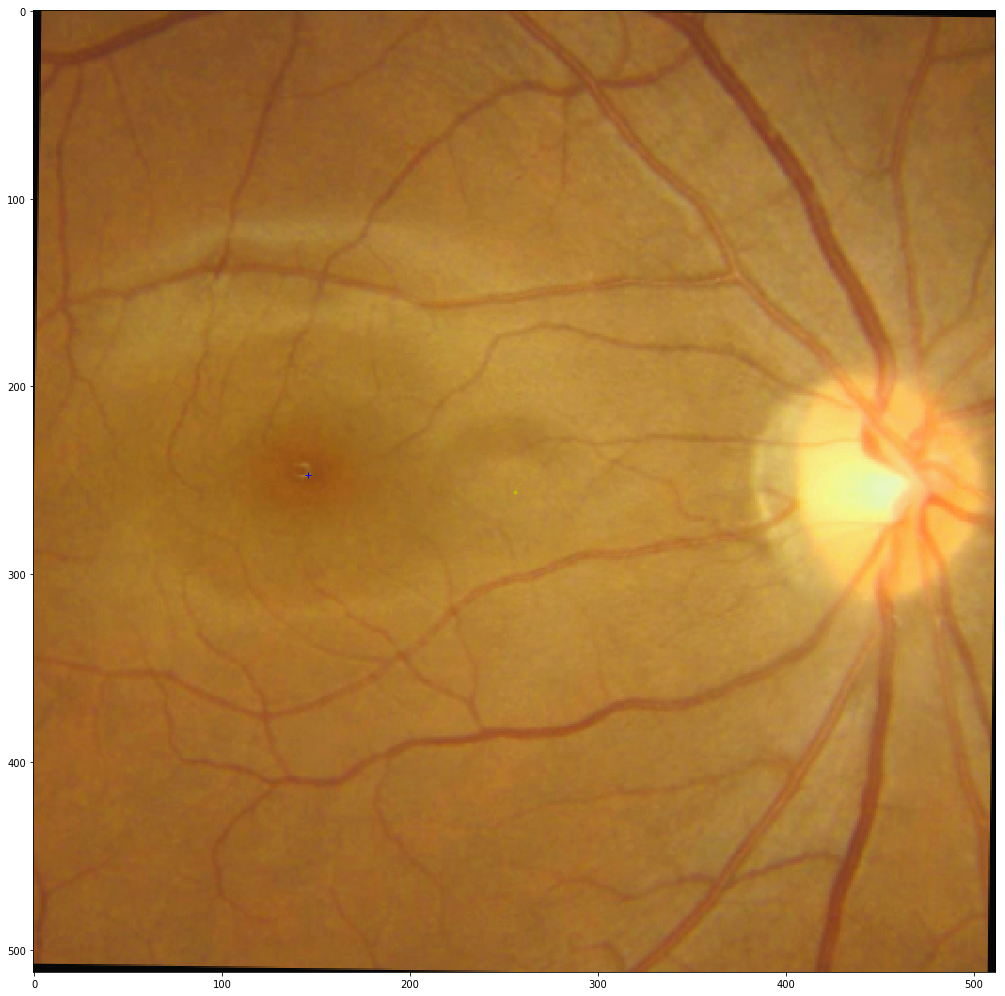

In [ ]:
### present five fundus images and corresponding ground truths in the _train Dataset

plt.figure(figsize=(100, 100))
for i in range(1):
    fundus_img, lab = _train.__getitem__(66)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0)) # C, H, W → H, W, C
    plt.plot(0.5*image_size, 0.5*image_size,'y.')
    plt.plot(lab[0]*image_size, lab[1]*image_size,'b+')
    # plt.axis("off")
    print(lab)

[0.23314252 0.4890032 ]


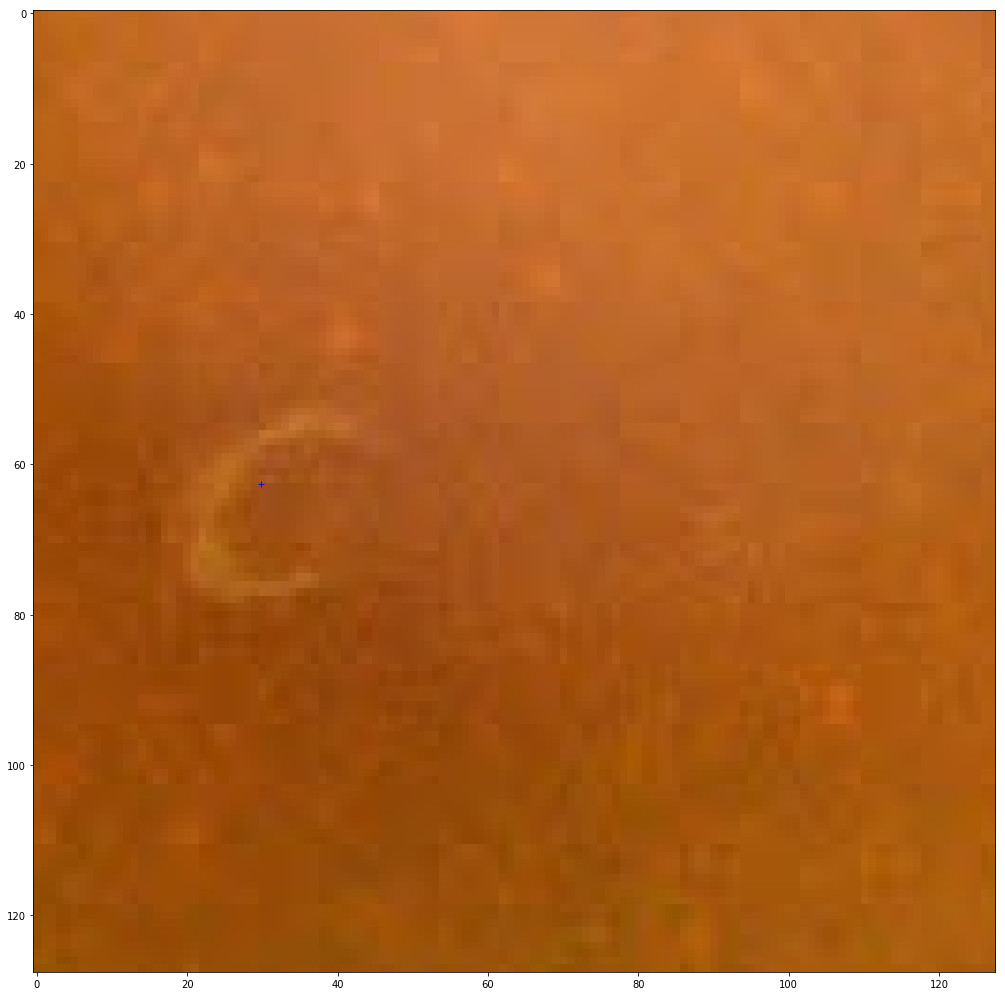

In [ ]:
### present five fundus images and corresponding ground truths in the _val Dataset

plt.figure(figsize=(100, 100))
for i in range(1):
    fundus_img, lab = _val.__getitem__(4) # 0084, 0054, 0071, 0046, 0045
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    plt.plot(lab[0]*128, lab[1]*128,'b+')
    # plt.axis("off")
    print(lab)

### Network

This baseline used ResNet50 to extract the feature from fundus images.
The detailed introduction of ResNet50 can be found at https://arxiv.org/pdf/1512.03385.pdf .  

The code of ResNet50 in PaddlePaddle framework can be found at https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/models/resnet50_cn.html#resnet50 .

In [5]:
class Network_resnet34(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet34, self).__init__()
        self.resnet = resnet34(pretrained=True, num_classes=0) # remove final fc 输出为[?, 1024, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(1024, 512)   
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [6]:
class Network_resnet50(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet50, self).__init__()
        self.resnet = resnet50(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [7]:
class Network_resnet101(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet101, self).__init__()
        self.resnet = resnet101(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [8]:
class Network_resnet152(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet152, self).__init__()
        self.resnet =  resnet152(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

### Utils

In [9]:
# compute ED and loss
# cal_ed computes the average ED of a batch when training
def cal_ed(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):
        logit_tmp = logit[i,:].numpy()
        label_tmp = label[i,:].numpy()
        # print('cal_coordinate_loss_ed', logit_tmp, label_tmp)        
        ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
        # print('ed_tmp:', ed_tmp[0][0])
        ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    return ed_l

# cal_ed_val computes the average ED of a batch when validation
def cal_ed_val(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):
        logit_tmp = logit[i,:]
        label_tmp = label[i,:]
        ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
        ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    
    return ed_l

# loss = alpha*MSE Loss + (1-alpha) *ED
def cal_coordinate_Loss(logit, label, alpha = 0.5):  # alpha =0.4
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    alpha = alpha
    mse_loss = nn.MSELoss(reduction='mean')

    mse_x = mse_loss(logit[:,0],label[:,0])
    mse_y = mse_loss(logit[:,1],label[:,1])
    mse_l = 0.5*(mse_x + mse_y)
    # print('mse_l', mse_l)

    ed_loss = []
    # print(logit.shape[0])
    for i in range(logit.shape[0]):
        logit_tmp = logit[i,:].numpy()
        label_tmp = label[i,:].numpy()
        # print('cal_coordinate_loss_ed', logit_tmp, label_tmp)        
        ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
        # print('ed_tmp:', ed_tmp[0][0])
        ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    # print('ed_l', ed_l)
    # print('alpha', alpha)
    loss = alpha * mse_l + (1-alpha) * ed_l
    # print('loss in function', loss)
    return loss

In [ ]:
# Logging
#current date and time
now = datetime.now()
format = "%m_%d_%Y"
date = now.strftime(format)

# Initialize logging
# logging.root.handlers = []
logging.basicConfig(
    level=logging.WARNING,  # level CRITICAL > ERROR > WARNING > INFO > DEBUG
    filename="{0}/{1}.log".format('log/', date),
    format='[%(asctime)s] %(levelname)s - %(message)s',
    datefmt='%H:%M')

# set up logging to console
console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
# set a format which is simpler for console use
formatter = logging.Formatter('%(levelname)-8s %(message)s')
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

In [10]:
### Training function

def train(model, iters, train_dataloader, val_dataloader, optimizer, log_interval, evl_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_ED_list = []
    best_ED = sys.float_info.max
    while iter < iters:
        for img, lab in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_imgs = (img / 255.).astype('float32')
            label = lab.astype("float32")

            logits = model(fundus_imgs)
            loss = cal_coordinate_Loss(logits, label)
            # print('loss in train',loss)

            for p,l in zip(logits.numpy(), label.numpy()):
                avg_ED_list.append([p,l])
            
            # print('avg_ED_list', avg_ED_list)
            loss.backward()
            optimizer.step()
            model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])
            
            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                # print(avg_loss)
                avg_ED_list = np.array(avg_ED_list)
                avg_ED = cal_ed_val(avg_ED_list[:, 0], avg_ED_list[:, 1]) # cal_ED
                # print('ed in training', avg_ED)
                avg_loss_list = []
                avg_ED_list = []
                
                # logging.warning("[TRAIN] iter={}/{} avg_loss={:.5f} avg_ED={:.5f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_ED={:.4f}".format(iter, iters, avg_loss, avg_ED[0][0]))

            if iter % evl_interval == 0:
                avg_loss, avg_ED = val(model, val_dataloader)
                print("[EVAL] iter={}/{} avg_loss={:.4f} ED={:.4f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                # if avg_ED <= best_ED :
                if avg_ED <= 0.025 and avg_ED <= best_ED:         # change the saving condition to...
                    best_ED = avg_ED[0][0]
                    paddle.save(model.state_dict(),
                            os.path.join('trained_models',"best_model_{:.4f}".format(best_ED), 'model.pdparams'))
                    paddle.save(optimizer.state_dict(), 
                            os.path.join('trained_models',"best_model_{:.4f}".format(best_ED), 'optimizer.pdopt'))
                model.train()

### validation function

def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            
            logits = model(fundus_imgs)
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_coordinate_Loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, ED

### Training the 1st Network

In [11]:
### generate training Dataset, Dataloader and validation Dataset, Dataloder for the 1st Network
img_train_transforms = trans.ComposeWithPoint([         
    trans.RandomHorizontalFlipWithPoint(),
    trans.RandomVerticalFlipWithPoint(),
    trans.RandomRotationWithPoint(60),
    # trans.ColorJitterWithPoint(0.2, 0.2, 0.2, 0.05)
])

# ComposeWithPoint is defined by Marco
img_val_transforms = trans.ComposeWithPoint([

])
# Dataset
train_dataset = FundusDataset(image_file = train_filelists, 
                              fundus_transforms = img_train_transforms,   
                              gt_file=gt_file,
                       )

val_dataset = FundusDataset(image_file = val_filelists, 
                            fundus_transforms = img_val_transforms,
                            gt_file=gt_file,
                       )

# train_dataset = FundusDataset(image_file = images_file, 
#                        gt_file=gt_file,
#                        filelists=train_filelists)

# val_dataset = FundusDataset(image_file = images_file, 
#                        gt_file=gt_file,
#                        filelists=val_filelists)

# generate a _train and a _val Dataset for presenting images in the training dataset

### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


[0.4160269  0.48935333]


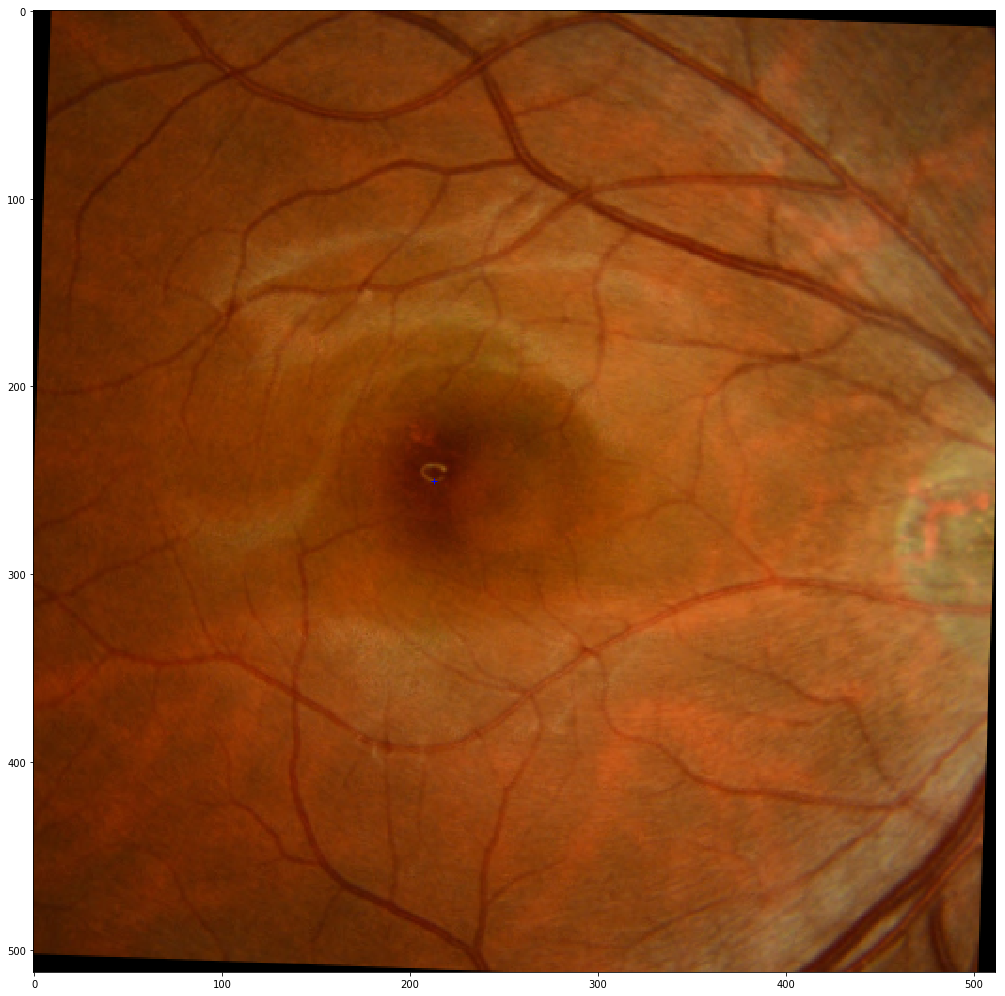

In [12]:
### present five fundus images and corresponding ground truths in the train Dataset
plt.figure(figsize=(100, 100))
for i in range(1):
    fundus_img, lab = train_dataset.__getitem__(8)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.plot(lab[0]*image_size, lab[1]*image_size,'b+')
    # plt.axis("off")
    print(lab)

(3, 512, 512)
[0.6665909 0.5869471]


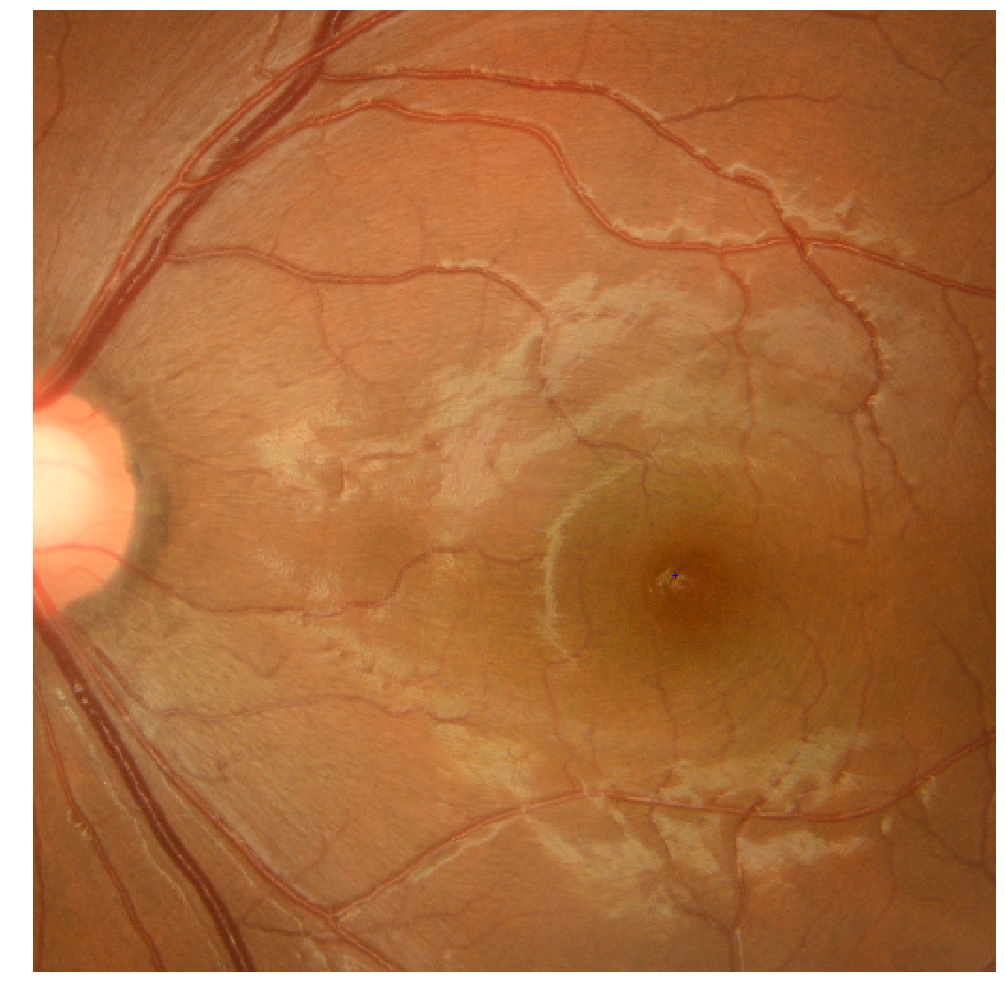

In [13]:
### present five fundus images and corresponding ground truths in the val Dataset

plt.figure(figsize=(100, 100))
for i in range(1):
    fundus_img, lab = val_dataset.__getitem__(8)
    print(fundus_img.shape)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.plot(lab[0]*image_size, lab[1]*image_size,'b+')
    plt.axis("off")
    print(lab)

In [ ]:
### Training the 1st Network 
### Model code was used to generate Model instance, and Optimizer were defined for subsequent training.

# model = Network()  #resnet50
model = Network_resnet101()

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
print(init_lr)

# criterion = cal_coordinate_Loss()

### training process
import warnings
# ignore warnings "Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-no"
# refer to https://blog.csdn.net/time_forgotten/article/details/104792200

# warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=32, evl_interval=160)

[TRAIN] iter=32/15000 avg_loss=0.0199 avg_ED=0.2116
[TRAIN] iter=64/15000 avg_loss=0.0102 avg_ED=0.1272
[TRAIN] iter=96/15000 avg_loss=0.0084 avg_ED=0.1221
[TRAIN] iter=128/15000 avg_loss=0.0028 avg_ED=0.0858
[TRAIN] iter=160/15000 avg_loss=0.0016 avg_ED=0.0740
[EVAL] iter=160/15000 avg_loss=0.0021 ED=0.0899
[TRAIN] iter=192/15000 avg_loss=0.0014 avg_ED=0.0705
[TRAIN] iter=224/15000 avg_loss=0.0014 avg_ED=0.0698
[TRAIN] iter=256/15000 avg_loss=0.0014 avg_ED=0.0705
[TRAIN] iter=288/15000 avg_loss=0.0015 avg_ED=0.0705
[TRAIN] iter=320/15000 avg_loss=0.0014 avg_ED=0.0693
[EVAL] iter=320/15000 avg_loss=0.0019 ED=0.0852
[TRAIN] iter=352/15000 avg_loss=0.0015 avg_ED=0.0704
[TRAIN] iter=384/15000 avg_loss=0.0014 avg_ED=0.0704
[TRAIN] iter=416/15000 avg_loss=0.0015 avg_ED=0.0696
[TRAIN] iter=448/15000 avg_loss=0.0014 avg_ED=0.0707
[TRAIN] iter=480/15000 avg_loss=0.0014 avg_ED=0.0695
[EVAL] iter=480/15000 avg_loss=0.0020 ED=0.0858
[TRAIN] iter=512/15000 avg_loss=0.0014 avg_ED=0.0696
[TRAIN] ite

### Get Predicted Results of the 1st Network  
pred_xy = {1: (x,y), 45:(x,y),... }  

In [ ]:
# Get Predicted Results of the 1st Network
best_model_path = "trained_models/best_model_0.0232/model.pdparams"
model = Network_resnet101()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

### gerenate the test Dataset
test1_filelists = images_file
test1_dataset = FundusDataset(image_file = test1_filelists, 
                             fundus_transforms = None ,
                       mode='test') # without Data augmentation when testing

pred_xy={}
# cache=[]
for fundus_img, idx, h, w, fh, fw in test1_dataset:   # h,w is the original size of fundus images
    fundus_img = fundus_img[np.newaxis, ...]         # h,w is the size of cropped images in 1st Segment Training
    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))    
    logits = model(fundus_img)
    pred_coor = logits.numpy()
    # print(pred_coor)

    # map to the orignal image cooridinate system
    fx = pred_coor[0][0] * fw  # fx = fx_nor * fw 
    fy = pred_coor[0][1] * fh
    x= fx + (w-fw)/2
    y= fy + (h-fh)/2  
    pred_xy[int(idx[-8:-4])]=(x,y)
    # cache.append([idx[:-10], x, y])
print(len(pred_xy))
# print(pred_xy)

2021-08-30 11:07:03,627 - INFO - unique_endpoints {''}
2021-08-30 11:07:03,628 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-08-30 11:07:04,498 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


100


In [ ]:
# visualize the prediction (test)
i='0046'
k='training_data/multi-modality_images/'+ i + '/'+ i+'.jpg'
plt.figure(figsize=(30, 30))
img=cv2.imread(k)[:, :, ::-1]

plt.imshow(img)  
# l= labels[0,:].numpy()
# plt.plot(l[0]*image_size, l[1]*image_size,'r+') 
plt.plot(pred_xy[int(i)][0], pred_xy[int(i)][1],'b+') 

### Training the 2nd Network 

In [ ]:
# FundusDataset2 of the 2nd (tiny) network 
class FundusDataset2(Dataset):
    def __init__(self,  image_file, pred_xy, gt_file=None, fundus_transforms=None,filelists=None, mode='train'):
        super(FundusDataset2, self).__init__()
        self.fundus_transforms =  fundus_transforms
        self.mode = mode
        self.image_path = image_file
        # image_idxs = os.listdir(self.image_path)
        image_idxs = self.image_path   # the list of fundus images' path
        self.gt_file = gt_file
        self.pred_xy= pred_xy # the predicted absolute coordinates of macular fovea was saved in pred_xy as a dict 
        # self.crop=crop

        if self.mode == 'train':
            label = {int(row['data']): row[1:].values 
                        for _, row in pd.read_excel(gt_file).iterrows()}
            self.file_list = [[image_idxs[i], label[int(image_idxs[i][-8:-4])], pred_xy[int(image_idxs[i][-8:-4])]] 
                                for i in range(len(image_idxs))]
            # print(self.file_list)

        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], pred_xy[int(image_idxs[i][-8:-4])], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label, pred_fovea = self.file_list[idx]   # pred_fovea is a tuple
        px, py = int(pred_fovea[0]), int(pred_fovea[1])      # px, py is the absolute coordinate in original image
        fundus_img_path = real_index    # real_index = absolute path of fundus imgs 
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = fundus_img.shape   # h,w,c is the original shape

        # Crop the Region of Interest
        top = py - 63
        left= px - 63
        mh, mw = 128,128
        fundus_img= F.crop(fundus_img, top, left, mh, mw)

        # Crop ROI of label
        if self.mode == 'train':
            x= float(label[0])
            y= float(label[1])
            
            mx = x - left  # map the label into cropped image(fw, fh) coordiante system
            my = y - top  
            # print("%.f, %.f, %.f, %.f"%(w,fw,x,fx))
            # print("%.f, %.f, %.f, %.f"%(h,fh,y,fy))
            # Normalization
            label_nor = (mx/mw, my/mh)  
            label_nor = np.array(label_nor).astype('float32').reshape(2)  # from tuple to np.array

        # without Resize in tiny network
        # fundus_re = cv2.resize(fundus_img,(image_size, image_size))
        # Data Augmengtation
        if self.fundus_transforms is not None:
            fundus_img, label_nor[0], label_nor[1]= self.fundus_transforms(fundus_img, label_nor[0], label_nor[1])
            
        img = fundus_img.transpose(2, 0, 1) # H, W, C -> C, H, W
        # img = fundus_re.astype(np.float32)
        
        if self.mode == 'test':
            return img, real_index, h, w, top, left
        if self.mode == 'train':
            return img, label_nor

    def __len__(self):
        return len(self.file_list)

In [ ]:
### Data Cleaner 
bad_train_labels = ['0016','0022','0030','0032','0058','0069','0087','0089']
for i in bad_train_labels:
    b= 'training_data/multi-modality_images/'+ i + '/'+ i +'.jpg'
    if b in train_filelists:
        train_filelists.remove(b)
bad_val_labels= 'training_data/multi-modality_images/0084/0084.jpg'
val_filelists.remove(bad_val_labels)
print(len(train_filelists))
# print(train_filelists)
print(val_filelists)

# find out if bad labels are still exist
count =[]
for i in bad_train_labels:
    b= 'training_data/multi-modality_images/'+ i + '/'+ i +'.jpg'
    if b in train_filelists:
        count.append(b)
print(count)

ValueError: list.remove(x): x not in list

In [ ]:
# generate training Dataset, Dataloader and validation Dataset, Dataloader for the 2nd Network
img_train_transforms = trans.ComposeWithPoint([         
    trans.RandomHorizontalFlipWithPoint(),
    trans.RandomVerticalFlipWithPoint(),
    trans.RandomRotationWithPoint(30),
    trans.ColorJitterWithPoint(0.2, 0.2, 0.2, 0.05)  # 0.4, 0.4, 0.4, 0.1 brightness, contrast, saturation and hue
])

# ComposeWithPoint is defined by Marco
img_val_transforms = trans.ComposeWithPoint([

])

train_dataset = FundusDataset2(image_file = train_filelists, 
                              pred_xy=pred_xy ,
                              fundus_transforms = img_train_transforms,   
                              gt_file=gt_file,
                       )

val_dataset = FundusDataset2(image_file = val_filelists, 
                            pred_xy= pred_xy ,
                            fundus_transforms = img_val_transforms,
                            gt_file=gt_file,
                       )
            
### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/home/aistudio/transforms.py:770: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:773: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


[0.7710524  0.24944974]
[0.86060596 0.42120805]
[0.13094443 0.5065445 ]
[0.8228485  0.32107627]
[0.15044904 0.38142946]
[0.26328737 0.7832172 ]
[0.1310518  0.48895168]
[0.86601895 0.5476967 ]
[0.14856245 0.61285603]
[0.7880893 0.7307583]


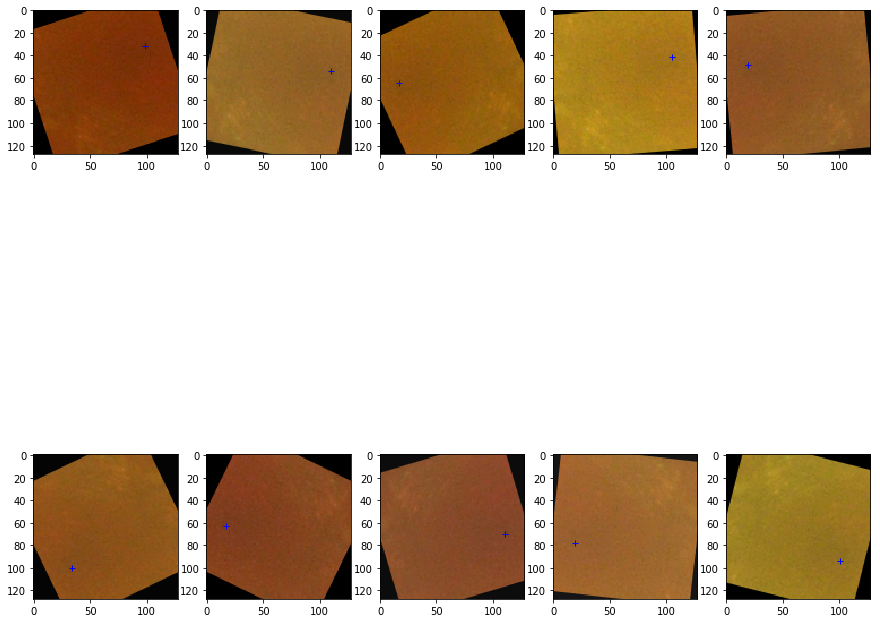

In [ ]:
# present fundus images and corresponding ground truths i in 2nd Network Training Period
plt.figure(figsize=(15, 15))
for i in range(10):
    fundus_img, lab = train_dataset.__getitem__(11)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.plot(lab[0]*128, lab[1]*128,'b+')
    # plt.axis("off")
    print(lab)

In [ ]:
### Training the 2nd Network 
# the results should be less than 0.1856 theoritically
model = Network_resnet101()
# para_state_dict = paddle.load("trained_models/best_model_0.0232/model.pdparams")
model.set_state_dict(para_state_dict)

init_lr = 1e-3
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
print(init_lr)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=30, evl_interval=180)

2021-08-30 16:26:18,184 - INFO - unique_endpoints {''}
2021-08-30 16:26:18,186 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-08-30 16:26:18,785 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


0.001
[TRAIN] iter=30/15000 avg_loss=0.0223 avg_ED=0.2121
[TRAIN] iter=60/15000 avg_loss=0.0205 avg_ED=0.1938
[TRAIN] iter=90/15000 avg_loss=0.0151 avg_ED=0.1855
[TRAIN] iter=120/15000 avg_loss=0.0157 avg_ED=0.1847
[TRAIN] iter=150/15000 avg_loss=0.0157 avg_ED=0.1845
[TRAIN] iter=180/15000 avg_loss=0.0148 avg_ED=0.1846
[EVAL] iter=180/15000 avg_loss=0.0082 ED=0.1552
[TRAIN] iter=210/15000 avg_loss=0.0161 avg_ED=0.1847
[TRAIN] iter=240/15000 avg_loss=0.0151 avg_ED=0.1846
[TRAIN] iter=270/15000 avg_loss=0.0225 avg_ED=0.1846
[TRAIN] iter=300/15000 avg_loss=0.0153 avg_ED=0.1841
[TRAIN] iter=330/15000 avg_loss=0.0157 avg_ED=0.1852
[TRAIN] iter=360/15000 avg_loss=0.0186 avg_ED=0.1847
[EVAL] iter=360/15000 avg_loss=0.0080 ED=0.1543
[TRAIN] iter=390/15000 avg_loss=0.0157 avg_ED=0.1843
[TRAIN] iter=420/15000 avg_loss=0.0151 avg_ED=0.1842
[TRAIN] iter=450/15000 avg_loss=0.0161 avg_ED=0.1841
[TRAIN] iter=480/15000 avg_loss=0.0153 avg_ED=0.1845
[TRAIN] iter=510/15000 avg_loss=0.0177 avg_ED=0.1842


KeyboardInterrupt: 

### Incremental Training/ Transfer Learning

In [ ]:
print(len(train_filelists))

82


In [105]:
### Incremental Training/ Transfer Learning Code
model = Network_resnet101()

optimizer_type = 'sgd'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(1e-4, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=1e-4, parameters=model.parameters(), 
                                     weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
    
para_state_dict = paddle.load("trained_models/best_model_0.0195/model.pdparams")
# opt_state_dict = paddle.load("trained_models/best_model_0.0195/optimizer.pdopt")

model.set_state_dict(para_state_dict)
# optimizer.set_state_dict(opt_state_dict)

iters = 15000

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=32, evl_interval=160)

2021-08-30 23:00:36,292 - INFO - unique_endpoints {''}
2021-08-30 23:00:36,293 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-08-30 23:00:36,878 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


[TRAIN] iter=32/15000 avg_loss=0.0002 avg_ED=0.0214
[TRAIN] iter=64/15000 avg_loss=0.0002 avg_ED=0.0220
[TRAIN] iter=96/15000 avg_loss=0.0002 avg_ED=0.0203
[TRAIN] iter=128/15000 avg_loss=0.0002 avg_ED=0.0213
[TRAIN] iter=160/15000 avg_loss=0.0002 avg_ED=0.0216
[EVAL] iter=160/15000 avg_loss=0.0002 ED=0.0193
[TRAIN] iter=192/15000 avg_loss=0.0002 avg_ED=0.0205
[TRAIN] iter=224/15000 avg_loss=0.0002 avg_ED=0.0211
[TRAIN] iter=256/15000 avg_loss=0.0002 avg_ED=0.0206
[TRAIN] iter=288/15000 avg_loss=0.0002 avg_ED=0.0218
[TRAIN] iter=320/15000 avg_loss=0.0002 avg_ED=0.0202
[EVAL] iter=320/15000 avg_loss=0.0002 ED=0.0198
[TRAIN] iter=352/15000 avg_loss=0.0002 avg_ED=0.0206
[TRAIN] iter=384/15000 avg_loss=0.0002 avg_ED=0.0201
[TRAIN] iter=416/15000 avg_loss=0.0002 avg_ED=0.0214
[TRAIN] iter=448/15000 avg_loss=0.0002 avg_ED=0.0206
[TRAIN] iter=480/15000 avg_loss=0.0002 avg_ED=0.0213
[EVAL] iter=480/15000 avg_loss=0.0002 ED=0.0193
[TRAIN] iter=512/15000 avg_loss=0.0001 avg_ED=0.0196
[TRAIN] ite

Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle12

SystemError: (Fatal) Blocking queue is killed because the data reader raises an exception.
  [Hint: Expected killed_ != true, but received killed_:1 == true:1.] (at /paddle/paddle/fluid/operators/reader/blocking_queue.h:158)


### Experimental Records  
1st Training: Baseline lr=1e-4 0.0316 (*2=0.0632)  
2nd Training: Baseline lr=1e-3 0.0259 (*2=0.0518, 3200 iters)   

**local cropping to 1024×1024 the results (normalized ED) will be about 2 times bigger than baseline  
image_size =256 or 512 won't change the normalized Euclidean distance  
~~if use local  cropping to 1024×1024, the results will be about 4 times bigger than baseline  
if use global cropping,              the results will be about 2 times bigger than baseline~~**    
3rd Training: resnet50 + *Data Augmentation + local cropping to 1024×1024*   0.0568 (3000-4000 iters)  
4th Training: resnet101 + Data Augmentation + local cropping to 1024×1024 0.0342(4100-4300 iters)  
4th Incremental Training (sgd): 0.0239(2880 iters) 0.0236 (4640 iters) **0.0232(7840 iters)**  
4th Incremantal Training (adam): + data cleaner 0.0195 (4640 iters)  0.0202 (3840 iters)  
4th Incremental Training: 0.0193 (180 iters) **0.0189** (960 iters)    
5th Training: resnet152 + Data Augmentation + local cropping to 1024×1024 0.884 (3000 iters) 0.0912(3700 iters) **overfitting**    
6th Training: resnet101 + global cropping + *alpha=0.6* 0.0292 (>5000iters)   

**2nd Segment Training**  
*color jitter will slow down the speed of training*  
7th Training: resnet50 + color jitter + micro features  0.1836 (/8 =0.02295)  
8th Training: resnet101 + color jitter + micro features + data cleaner 0.1543 (/8=0.0194, 360 iters)  




### Evaluation and Visualiztion

In [14]:
val_filelists[7]

'training_data/multi-modality_images/0081/0081.jpg'

In [ ]:
# Outliers (max error points):val_filelists[0] 0084, val_filelists[4] 0045, val_filelists[6] 0023
#                             val_filelists[7] 0081
#               Their ED are [[0.05809087]] [[0.03269244]] [[0.02846074]] [[0.04231678]]  respectiively
#                            [[0.06055317]] [[0.03389655]] [[0.02804876]] [[0.04355107]]
                        #    [[0.05937266]] [[0.03427971]] [[0.0288808]] [[0.04117233]]
def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []  # ?
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            print(data)
            
            logits = model(fundus_imgs)
            print(logits)
            # Visualiztion
            print(labels)
            # print(fundus_imgs)
            
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_coordinate_Loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()
    # print(ED)

    return avg_loss, ED, logits, labels, fundus_imgs

# val_filelists was defined just now
# ['training_data/multi-modality_images/0084/0084.jpg', 'training_data/multi-modality_images/0054/0054.jpg', 'training_data/multi-modality_images/0071/0071.jpg', 'training_data/multi-modality_images/0046/0046.jpg', 'training_data/multi-modality_images/0045/0045.jpg', 'training_data/multi-modality_images/0040/0040.jpg', 'training_data/multi-modality_images/0023/0023.jpg', 'training_data/multi-modality_images/0081/0081.jpg', 'training_data/multi-modality_images/0011/0011.jpg', 'training_data/multi-modality_images/0001/0001.jpg']
img_val_transforms = trans.ComposeWithPoint([

])
# val_filelists[8]
val_dataset = FundusDataset(image_file = [val_filelists[8]], 
                            fundus_transforms = img_val_transforms,
                            gt_file=gt_file
                       )
val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=1, shuffle=True, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

best_model_path = "trained_models/best_model_0.0232/model.pdparams"

model= Network_resnet101()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

avg_loss, ED, logits, labels, fundus_imgs= val(model,val_loader)
print(ED)


2021-08-29 19:03:47,350 - INFO - unique_endpoints {''}
INFO     unique_endpoints {''}
2021-08-29 19:03:47,352 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
INFO     File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-08-29 19:03:47,973 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams
INFO     Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


[Tensor(shape=[1, 3, 512, 512], dtype=uint8, place=CUDAPlace(0), stop_gradient=True,
       [[[[132, 127, 132, ..., 128, 130, 129],
          [131, 125, 130, ..., 129, 130, 129],
          [125, 126, 131, ..., 130, 129, 123],
          ...,
          [133, 128, 124, ..., 111, 119, 127],
          [135, 127, 124, ..., 116, 119, 117],
          [134, 128, 125, ..., 119, 118, 118]],

         [[73 , 68 , 70 , ..., 71 , 73 , 72 ],
          [71 , 66 , 71 , ..., 71 , 72 , 71 ],
          [67 , 68 , 71 , ..., 72 , 71 , 68 ],
          ...,
          [68 , 64 , 60 , ..., 59 , 65 , 72 ],
          [70 , 62 , 59 , ..., 61 , 64 , 64 ],
          [71 , 65 , 62 , ..., 65 , 65 , 65 ]],

         [[33 , 28 , 29 , ..., 28 , 30 , 29 ],
          [34 , 26 , 31 , ..., 31 , 32 , 31 ],
          [29 , 30 , 34 , ..., 32 , 31 , 27 ],
          ...,
          [25 , 23 , 22 , ..., 35 , 35 , 36 ],
          [28 , 22 , 21 , ..., 33 , 30 , 26 ],
          [28 , 24 , 24 , ..., 28 , 29 , 32 ]]]]), Tensor(shape=[1,

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


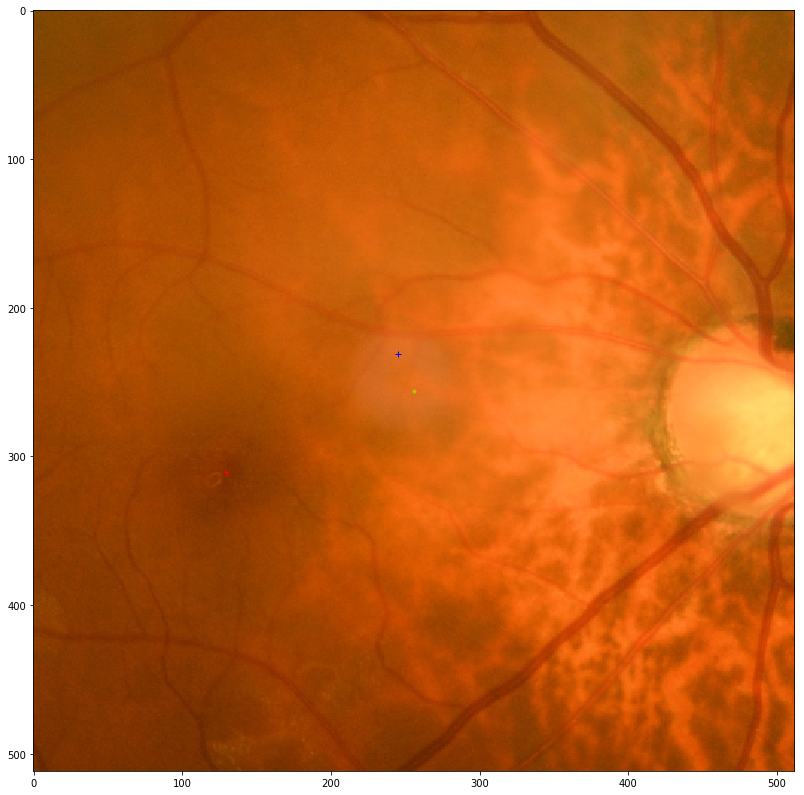

In [ ]:
f_imgs,lab_nor = val_dataset.__getitem__(0)
plt.figure(figsize=(14, 14))
plt.imshow(f_imgs.transpose(1, 2, 0))  
plt.plot(0.5*image_size, 0.5*image_size,'y.')
r= logits[0,:].numpy()
l= labels[0,:].numpy()
plt.plot(l[0]*image_size, l[1]*image_size,'r+') 
plt.plot(r[0]*image_size, r[1]*image_size,'b+')  # logit[:,0],label[:,0]

### Inference

In [15]:
!unzip -o /home/aistudio/data/data103109/val_data.zip  -d /home/aistudio/val_data

In [31]:
# Inference should implement the reverse process of data augmentation:
# Reverse Processing of Crop Center Square (fh,fw)→（h,w）
# Resize (didn't change the relative position), without Data augmentation when testing
### inference(testing) process, load the model parameters

best_model_path = "trained_models/best_model_0.0195/model.pdparams"
model = Network_resnet101()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

### gerenate the test Dataset
test_path = 'val_data/multi-modality_images'  # the path to the training data
image_idxs = os.listdir(test_path)
file_list = [image_idxs[i] for i in range(len(image_idxs))] 
# print(file_list) 
test_filelists =[]         # the list of fundus images' path
for i in range(len(image_idxs)):
    real_index = file_list[i]
    fundus_img_path = os.path.join(test_path, real_index, real_index + '.jpg')
    test_filelists.append(fundus_img_path)
test_filelists.sort()
print(test_filelists)

# test_path = 'multi-modality_images/0101/0101/'  # the path to the training data
# test_filelists = os.listdir(test_path)
# print(type(test_filelists))

# test_filelists = [test_filelists[i] for i in range(len(test_filelists))] 
# the filelist to the testing data, in the format of multi-modality_images/0101/0101/0_image.jpg
                                                               # multi-modality_images/0101/0101/10_image.jpg
                                                               # multi-modality_images/0101/0101/111_image.jpg
test_dataset = FundusDataset(image_file = test_filelists, 
                             fundus_transforms = None, 
                       mode='test') # without Data augmentation when testing

2021-09-05 23:45:08,314 - INFO - unique_endpoints {''}
2021-09-05 23:45:08,316 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-09-05 23:45:09,009 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


['val_data/multi-modality_images/0101/0101.jpg', 'val_data/multi-modality_images/0102/0102.jpg', 'val_data/multi-modality_images/0103/0103.jpg', 'val_data/multi-modality_images/0104/0104.jpg', 'val_data/multi-modality_images/0105/0105.jpg', 'val_data/multi-modality_images/0106/0106.jpg', 'val_data/multi-modality_images/0107/0107.jpg', 'val_data/multi-modality_images/0108/0108.jpg', 'val_data/multi-modality_images/0109/0109.jpg', 'val_data/multi-modality_images/0110/0110.jpg', 'val_data/multi-modality_images/0111/0111.jpg', 'val_data/multi-modality_images/0112/0112.jpg', 'val_data/multi-modality_images/0113/0113.jpg', 'val_data/multi-modality_images/0114/0114.jpg', 'val_data/multi-modality_images/0115/0115.jpg', 'val_data/multi-modality_images/0116/0116.jpg', 'val_data/multi-modality_images/0117/0117.jpg', 'val_data/multi-modality_images/0118/0118.jpg', 'val_data/multi-modality_images/0119/0119.jpg', 'val_data/multi-modality_images/0120/0120.jpg', 'val_data/multi-modality_images/0121/01

In [30]:
### The fundus images in the test dataset are localizated one by one

cache = []
for fundus_img, idx, h, w, fh, fw in test_dataset:   # h,w is the original size of fundus images
    fundus_img = fundus_img[np.newaxis, ...]    
    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))    
    logits = model(fundus_img)
    pred_coor = logits.numpy()
    # print(pred_coor)

    # fw, fh =1024, 1024 # for lcoal center square cropping
    # fh, fw = min(fundus_img_h, fundus_img_w), min(fundus_img_h, fundus_img_w)    # for global center square cropping

    # map to the orignal image cooridinate system
    fx = pred_coor[0][0] * fw  # fx = fx_nor * fw 
    fy = pred_coor[0][1] * fh
    x= fx + (w-fw)/2     # x, y is the absolute coordinate in original images
    y= fy + (h-fh)/2  
    cache.append([idx[-8:-4], x, y])

### save the predicted results in .csv file
submission_result = pd.DataFrame(cache, columns=['data', 'Fovea_X', 'Fovea_Y'])
submission_result[['data', 'Fovea_X', 'Fovea_Y']].to_csv("./Localization_Results.csv", index=False)

In [28]:
pd.read_csv('Localization_Results.csv', converters = {'data':str})

,data,Fovea_X,Fovea_Y
0,0101,1495.963013,1034.208252
1,0102,1476.907043,1039.170166
2,0103,1467.928314,1067.151367
3,0104,1493.119690,1007.654114
4,0105,1628.232483,1060.307495
...,...,...,...
95,0196,1477.824249,1027.706238
96,0197,1308.738190,1096.563599
97,0198,1647.205566,1099.223145
98,0199,1474.260101,1050.359497


### Summary

    This baseline realized the prediction of macular fovea coordinate value in 2D color fundus photos. The baseline model was ResNet50.	      
	Users can try other tricks on the basis of this baseline, such as joint training with optic disc localization or segmentation task, joint training with macular segmentation task, and achieving macular fovea localization from coarse to fine.